Load necessary packages

In [1]:
import json
import numpy as np
from rdkit import Chem
import torch
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')

/home/yinxia/miniconda3/envs/dd2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read docking scores and the corresponding smiles

In [2]:
def read_smiles(output_file):
    smiles = {}
    with open(output_file, 'r') as f:
        for line in f:
            orig_infos = line.strip().split(", ")
            if len(orig_infos) > 1:
                index = int(orig_infos[0])
                smiles[index] = {
                    "pdb_id": orig_infos[1],
                    "ref_smiles": orig_infos[2],
                    "hyp_smiles_list": [],
                }
                continue
            if line.strip() == "":
                continue
            smiles[index]["hyp_smiles_list"].append(line.strip().split("\t")[1])
    return smiles

def read_docking_scores(output_json_file):
    docking_scores = {}
    with open(output_json_file, 'r') as f:
        docking_scores = json.load(f)
    return docking_scores

def merge_smiles_and_docking_scores(smiles, docking_scores):
    for index, info in smiles.items():
        info["docking_scores"] = docking_scores[str(index)]["all"]
    return smiles


def get_top_k_smiles_and_scores(result, k=5):
    top_k_smiles_and_scores = {}
    for index, info in result.items():
        if len(info["hyp_smiles_list"]) == 0:
            continue
        sorted_index = np.argsort(info["docking_scores"])[:k]
        top_k_smiles_and_scores[index] = {
            "smiles": [info["hyp_smiles_list"][i] for i in sorted_index],
            "scores": [info["docking_scores"][i] for i in sorted_index],
            "index": sorted_index,
        }
    return top_k_smiles_and_scores


In [3]:
DB_prefix = "baseline_results/"

our_result = torch.load(DB_prefix + "our_results_redecode_new_scores.pt")
targetdiff_orig_result = torch.load(DB_prefix + "targetdiff_result_scores.pt")
resgen_result = torch.load(DB_prefix + "resgen_result_scores.pt")
pocket2mol_orig_result = torch.load(DB_prefix + "pocket2mol_result_scores.pt")
AR_orig_result = torch.load(DB_prefix + "ar_result_scores.pt")
ligan_result = torch.load(DB_prefix + "ligan_result_scores.pt")
ref_result = torch.load(DB_prefix + "ref_result_scores.pt")

In [4]:
our_topk = get_top_k_smiles_and_scores(our_result, k=200)
targetdiff_topk = get_top_k_smiles_and_scores(targetdiff_orig_result, k=200)
resgen_topk = get_top_k_smiles_and_scores(resgen_result, k=200)
pocket2mol_topk = get_top_k_smiles_and_scores(pocket2mol_orig_result, k=200)
AR_topk = get_top_k_smiles_and_scores(AR_orig_result, k=200)
ligan_topk = get_top_k_smiles_and_scores(ligan_result, k=200)

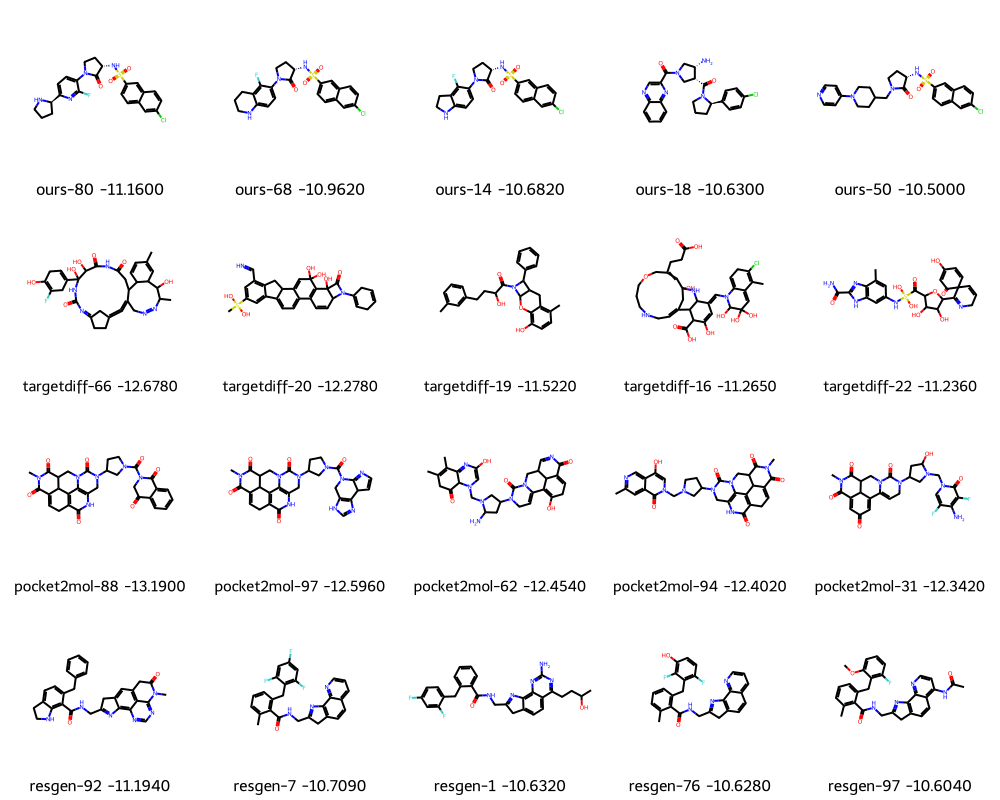

In [6]:
from rdkit import Chem
from rdkit import Chem
from rdkit.Chem import Draw

topK_to_viz = 5
keyid=7 
mols = []
legends = []

for s in our_topk[keyid]['smiles'][:topK_to_viz]:
    mols.append(Chem.MolFromSmiles(s))

for idx, s in enumerate(our_topk[keyid]['scores'][:topK_to_viz]):
    legends.append("ours-{} {:.4f}".format(our_topk[keyid]['index'][idx], s))

for s in targetdiff_topk[keyid]['smiles'][:topK_to_viz]:
    mols.append(Chem.MolFromSmiles(s))

for idx, s in enumerate(targetdiff_topk[keyid]['scores'][:topK_to_viz]):
    legends.append("targetdiff-{} {:.4f}".format(targetdiff_topk[keyid]['index'][idx], s))

for s in pocket2mol_topk[keyid]['smiles'][:topK_to_viz]:
    mols.append(Chem.MolFromSmiles(s))

for idx, s in enumerate(pocket2mol_topk[keyid]['scores'][:topK_to_viz]):
    legends.append("pocket2mol-{} {:.4f}".format(pocket2mol_topk[keyid]['index'][idx], s))

# for s in AR_topk[keyid]['smiles'][:topK_to_viz]:
#     mols.append(Chem.MolFromSmiles(s))

# for idx, s in enumerate(AR_topk[keyid]['scores'][:topK_to_viz]):
#     legends.append("AR-{} {:.4f}".format(AR_topk[keyid]['index'][idx], s))

# for s in ligan_topk[keyid]['smiles'][:topK_to_viz]:
#     mols.append(Chem.MolFromSmiles(s))

# for idx, s in enumerate(ligan_topk[keyid]['scores'][:topK_to_viz]):
#     legends.append("liG-{} {:.4f}".format(ligan_topk[keyid]['index'][idx], s))

if len(resgen_topk[str(keyid)]['smiles']) < topK_to_viz:
    print("resgen has no result for this target")
else:
    for s in resgen_topk[str(keyid)]['smiles'][:topK_to_viz]:
        mols.append(Chem.MolFromSmiles(s))

    for idx, s in enumerate(resgen_topk[str(keyid)]['scores'][:topK_to_viz]):
        legends.append("resgen-{} {:.4f}".format(resgen_topk[str(keyid)]['index'][idx], s))

img=Draw.MolsToGridImage(mols,molsPerRow=topK_to_viz,legends=legends)
img